# Определение стоимости автомобилей
___
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.
Критерии, которые важны заказчику:
* качество предсказания
* время обучения модели
* время предсказания модели
___
Цель этого проекта заключается в разработке модели, способной предсказывать рыночную стоимость автомобилей на основе их технических характеристик и комплектации.
___
В ходе проекта должны быть выполнены следующие шаги:
* Изучение общей информации
* Предобработка данных
* Обучение и сравнение нескольких моделей
* Выбор лучшей модели и  его обоснование в соответствии с требованиями заказчика
___
В качестве источника данных выступает файл autos.csv со следубщими столбцами
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

In [1]:
!pip install catboost lightgbm -q

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings('ignore')
import time

## Загрузка и предварительный просмотр данных

In [3]:
try:
    df_autos = pd.read_csv('autos.csv')
except:
    df_autos = pd.read_csv('/datasets/autos.csv')

In [4]:
df_autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df_autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Колонка Price не должна иметь нулевые значения, RegistrationYear тоже имеет явные выбросы - 9999 год, RegistrationYear вообще состоит из одних нулей, интересное распределение и у Kilometer как минимум половина всех значений равна 150000.

In [6]:
df_autos.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


## Предобработка данных

Посмотрим на долю пропусков в каждом столбце

In [7]:
df_autos.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
Repaired             0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

In [8]:
print('Процент данных с пропусками ', round(100 * (1 - df_autos.dropna().shape[0] / df_autos.shape[0]), 2) , '%', sep='')

Процент данных с пропусками 30.63%


Как видим доля данных с пропусками достаточно большая и их нельзя бездумно удалять, займёмся обработкой пропусков при создании пайплайна

Приведём все даты к типу datetime

In [9]:
df_autos[['DateCreated', 'LastSeen', 'DateCrawled']] = df_autos[['DateCreated', 'LastSeen', 'DateCrawled']].astype('datetime64[ns]')

In [10]:
df_autos['DateCrawled'].describe()

count                  354369
unique                 271174
top       2016-03-24 14:49:47
freq                        7
first     2016-03-05 14:06:22
last      2016-04-07 14:36:58
Name: DateCrawled, dtype: object

In [11]:
df_autos['DateCreated'].describe()

count                  354369
unique                    109
top       2016-04-03 00:00:00
freq                    13719
first     2014-03-10 00:00:00
last      2016-04-07 00:00:00
Name: DateCreated, dtype: object

In [12]:
df_autos['LastSeen'].describe()

count                  354369
unique                 179150
top       2016-04-06 13:45:54
freq                       17
first     2016-03-05 14:15:08
last      2016-04-07 14:58:51
Name: LastSeen, dtype: object

Мы рассматриваем объявления почти за 2 года с 2014 по 2016, при этом скачаны они были с матрта по апрель 2016 года, сразу видно что в некоторых случаях дата загрузки объявления меньше даты LastSeen, что не может быть правдой, так что проверим даты на соответствие

In [13]:
df_autos[df_autos['DateCrawled'] > df_autos['LastSeen']].shape[0]

1

In [14]:
df_autos[df_autos['RegistrationYear'] > df_autos['DateCreated'].dt.year].shape[0]

14530

In [15]:
df_autos[df_autos['RegistrationYear'] > df_autos['DateCrawled'].dt.year].shape[0]

14530

Не может такого быть, что год регистрации автомобиля больше года скачивания объявления или года создания анкеты, удалим такие данные

In [16]:
df_autos = df_autos[(df_autos['RegistrationYear'] < df_autos['DateCreated'].dt.year) & 
                    (df_autos['RegistrationYear'] < df_autos['DateCrawled'].dt.year) &
                    (df_autos['DateCrawled'] < df_autos['LastSeen'])]

Теперь удалим поля DateCreated, DateCrawled, PostalCode - они бесполезны при моделировании ведь не несут никакой информации о самом автомобиле, LastSeen - это поле вообще нам не будет достумно при оценке информации о только что загруженном автомобиле

In [17]:
df_autos = df_autos.drop(['DateCreated', 'LastSeen', 'DateCrawled', 'PostalCode'], axis=1)

Теперь рассмотри столбец с ценой

In [18]:
df_autos['Price'].describe()

count    296714.000000
mean       4674.904362
std        4627.710582
min           0.000000
25%        1200.000000
50%        2990.000000
75%        6890.000000
max       20000.000000
Name: Price, dtype: float64

Нулевая цена это явная ошибка, стоит удалить данные с явно аномально низкими ценами

In [19]:
df_autos = df_autos[df_autos['Price'] > 0]

Обратим внимание, что месяц регистрации выражен числом отдельно от года, это может сильно исказить картину, рассмотрим этот столбец и возможно объединим его с годом

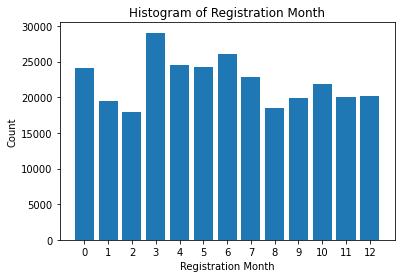

In [20]:
counts = df_autos['RegistrationMonth'].value_counts()
plt.bar(counts.index, counts.values)

plt.xlabel('Registration Month')
plt.ylabel('Count')
plt.title('Histogram of Registration Month')
plt.xticks(counts.index) 
plt.show()

13 месяцев в году это очень странно, причём количество регистраций в каждом месяце примерно равно, так что и не спишешь на опечатки. В этом столбце явно бредовые данные, причём не понятно как их исправлять, так что просто удалим этот признак

In [21]:
df_autos = df_autos.drop('RegistrationMonth', axis=1) 

При предварительном просмотре столбец с количеством фоток выглядел подозрительно, рассмотрим его

In [22]:
df_autos['NumberOfPictures'].describe()

count    288640.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

Всё по 0, удалим этот бесполезный столбец

In [23]:
df_autos = df_autos.drop('NumberOfPictures', axis=1) 

Посмотрим на столбец с мощностью автомобиля

In [24]:
df_autos['Power'].describe()

count    288640.000000
mean        113.912126
std         185.568435
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Мощность равная 0 и 20000 явные выбросы, возьмём только те автомобили, у которых мощность меньше 1000 и болше 0

In [25]:
df_autos = df_autos[(df_autos['Power'] > 0) & (df_autos['Power'] < 1000)]

Теперь посмотрим на годы регистрации

In [26]:
df_autos['RegistrationYear'].describe()

count    262749.000000
mean       2002.541220
std           7.461197
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2015.000000
Name: RegistrationYear, dtype: float64

Первый автомобиль был создан в 1885, так что ограничим снизу этой датой

In [27]:
df_autos = df_autos[(df_autos['RegistrationYear'] > 1885)]

Теперь проверим долю дубликатов

In [28]:
df_autos.duplicated().sum() / df_autos.shape[0]

0.12239002519581947

Стоит их удалить

In [29]:
df_autos = df_autos.drop_duplicates()

### Вывод по предобработке
* При анализе данных было выяснено, что в датасете есть достаточно большое количество объявлений которые являются заведомо неправильными - в них дата год регистрации автомобиля был больше года подачи объявления. 
* Также было удалено несколько бесполезных колонок таких как DateCreated, DateCrawled, PostalCode - они бесполезны при моделировании ведь не несут никакой информации о самом автомобиле и LastSeen - это поле вообще нам не будет достумно при оценке информации о только что загруженном автомобиле. 
* Поле с месяцем регистрации было удалено как недостоверное - в нём было 13 месяцев, также мы удали признак NumberOfPictures, ведь он состоял только из 0.
* В столбца с мощностью и годом регистрации автомобиля было найдено несколько явных выборосов - они были удалены.
* В данных было достаточно много дубликатов - 12%, все они были удалены.

## Создание пайплайна для обучения
Разделим данные на входные признаки и целевую переменную

In [30]:
X = df_autos.drop('Price', axis=1)
y = df_autos['Price']

Разделим данные на тренировочную и тестовую выборки

In [31]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Посмотрим на размерности полученных выборок

In [32]:
print("Размерность X_train:", X_train.shape)
print("Размерность y_train:", y_train.shape)
print("Размерность X_test:", X_test.shape)
print("Размерность y_test:", y_test.shape)

Размерность X_train: (184468, 9)
Размерность y_train: (184468,)
Размерность X_test: (46117, 9)
Размерность y_test: (46117,)


Выберем числовые и категориальные признаки

In [33]:
numeric_features = X.select_dtypes(exclude=['object']).columns
categorical_features = X.select_dtypes(include=['object']).columns

Создание пайплайна для предобработки данных

In [34]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler()) 
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

Воспользуемся созданным пайплайном

In [35]:
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

Обучим 3 разные модели и сравним их

In [36]:
results = []

In [37]:
param_grid = {
    'learning_rate': [0.01, 0.05],
    'n_estimators': [100, 200],
}
lgbm_model = LGBMRegressor(metric='rmse', verbosity=-1)
grid_search = GridSearchCV(estimator=lgbm_model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)

start_time = time.time()
grid_search.fit(X_train_transformed, y_train)
lgbm_train_time = (time.time() - start_time) / (4*3)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
lgbm_rmse = grid_search.best_score_

start_time = time.time()
lgbm_pred = best_model.predict(X_train_transformed)
lgbm_pred_time = time.time() - start_time

results.append(['LightGBM', lgbm_train_time, lgbm_pred_time, -lgbm_rmse, best_params])

In [38]:
param_grid = {
    'alpha': [0.01, 0.1]
}
lasso_model = Lasso()
grid_search_lasso = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=2, scoring='neg_root_mean_squared_error', n_jobs=-1)

start_time = time.time()
grid_search_lasso.fit(X_train_transformed, y_train)
lasso_train_time = (time.time() - start_time) / (2 * 2)

best_params_lasso = grid_search_lasso.best_params_
best_model_lasso = grid_search_lasso.best_estimator_
lasso_rmse = grid_search_lasso.best_score_

start_time = time.time()
lasso_pred = best_model_lasso.predict(X_train_transformed)
lasso_pred_time = time.time() - start_time

results.append(['Lasso', lasso_train_time, lasso_pred_time, -lasso_rmse, best_params_lasso])

In [39]:
param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.05, 0.1],
}

catboost_model = CatBoostRegressor(loss_function='RMSE', verbose=False)

grid_search_catboost = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)

start_time = time.time()
grid_search_catboost.fit(X_train_transformed, y_train)
catboost_train_time = (time.time() - start_time) / (4 * 3)

best_params_catboost = grid_search_catboost.best_params_
best_model_catboost = grid_search_catboost.best_estimator_
catboost_rmse = grid_search_catboost.best_score_

start_time = time.time()
catboost_pred = best_model_catboost.predict(X_train_transformed)
catboost_pred_time = time.time() - start_time

results.append(['CatBoost', catboost_train_time, catboost_pred_time, -catboost_rmse, best_params_catboost])

In [40]:
df_results = pd.DataFrame(results, columns=['Model', 'Training Time', 'Prediction Time', 'RMSE', 'Params'])
df_results

,Model,Training Time,Prediction Time,RMSE,Params
0,LightGBM,21.704828,3.220337,1671.606794,"{'learning_rate': 0.05, 'n_estimators': 200}"
1,Lasso,163.849790,0.003742,2665.106612,{'alpha': 0.1}
2,CatBoost,14.206676,0.360430,1604.752040,"{'iterations': 1000, 'learning_rate': 0.1}"


# Вывод
В ходе этого проекта были проведены следующие шаги
* Предобработка данных
    * При анализе данных было выяснено, что в датасете есть достаточно большое количество объявлений которые являются заведомо неправильными - в них дата год регистрации автомобиля был больше года подачи объявления. 
    * Также было удалено несколько бесполезных колонок таких как DateCreated, DateCrawled, PostalCode - они бесполезны при моделировании ведь не несут никакой информации о самом автомобиле и LastSeen - это поле вообще нам не будет достумно при оценке информации о только что загруженном автомобиле. 
    * Поле с месяцем регистрации было удалено как недостоверное - в нём было 13 месяцев, также мы удали признак NumberOfPictures, ведь он состоял только из 0.
    * В столбца с мощностью и годом регистрации автомобиля было найдено несколько явных выборосов - они были удалены.
    * В данных было достаточно много дубликатов - 12%, все они были удалены.
* Создания пайплайна
    * При предобработке была найдена большая доля пропусков и было принято решение использовать SimpleImputer в пайплайне для из заполнения
    * Для кодирования категориальных признаков использовался One-Hot_Encoder, для масштабирования числовых признаков - StandartScaler
* Обучение моделей
    * Для обучения и последующего сравнения было выбрано 3 модели LightGBMRegression, CatBoostRegression, LassoRegression
    * В ходе эксперимента было выяснено, что лучшая метрика получается у градиентных бустингов, при этом время обучения у них тоже значительно меньше, лучшим по времени обучения и метрике стал CatBoost c RMSE = 1589 и временем обучения 14.2с, по времени предсказания быстрее остальных -Lasso.
    
В качестве модели для оценки рыночной стоимости автомобиля я советую использовать CatBoost, ведь при небольшом проигрыше по времени предсказания она даёт выигрыш по точности.